In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2

import albumentations as A

In [2]:
train_transforms = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.GaussNoise(var_limit=0.03)
])

val_transforms = A.Compose([
    A.NoOp()
])

In [3]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [4]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [5]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    X = [os.path.join(x_path, image) for image in images]
    y = [os.path.join(y_path, mask) for mask in masks]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [6]:
def tf_dataset(x, y, transformations, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(lambda x, y: preprocess(x, y, transformations))
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y, transformations):

    def aug(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        augmented = transformations(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(aug, [x,y], [tf.float32, tf.int32])

    mask = tf.one_hot(mask, 3, dtype = tf.int32) #обязательно так как сегментация мультиклассовая

    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [7]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout, Lambda

def UNet(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
  
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    #bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #expansion path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_3Class(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [9]:
Ncl = 3  # Assuming this value, adjust if necessary
w = K.zeros(shape=(Ncl,))

def generalized_dice_coeff(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.cast(y_true, 'float32')
    print(y_pred.dtype, y_true.dtype)
    Ncl = y_pred.shape[-1]
    # w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0,1,2))
    w = 1.0/(w**2+0.000001)

    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)

In [10]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [11]:
np.random.seed(42)
tf.random.set_seed(42)
i = random.randint(0, 4308)

## Визуализация


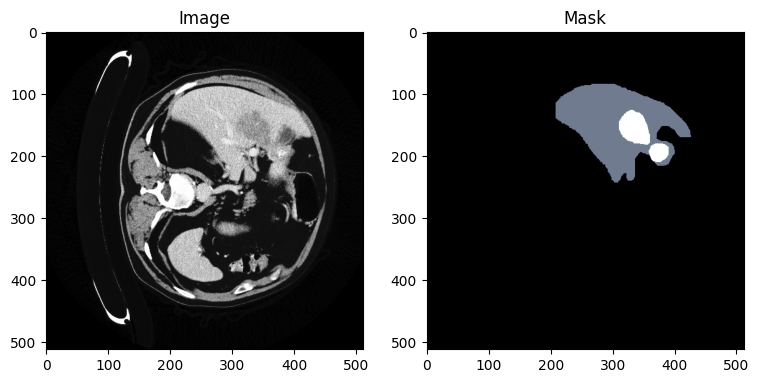

In [12]:
images_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan"
masks_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks"

train_x, train_y, valid_x, valid_y, test_x, test_y = load_data(images_path, masks_path)

visualize(image = read_image(train_x[i]), mask = read_mask(train_y[i]))

## Гиперпараметры модели

In [13]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
n_classes = 3

LR = 1e-4
batch_size = 4
epochs = 50

## Модель

In [14]:
model = UNet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(LR), metrics = ['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## Формирование датасета и обучение

In [15]:
train_dataset = tf_dataset(train_x, train_y, transformations=train_transforms, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, transformations=val_transforms, batch = batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

history_class = LossHistory()
# checkpointer = ModelCheckpoint('multiclass_liver_seg_UNet.hdf5', verbose=1, save_best_only=True)

callbacks = [
    ModelCheckpoint("multiclass_liver_seg_UNet_50epochs.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    # EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.001),
    TensorBoard(log_dir='logs'),
    history_class
]



In [16]:
# history = model.fit(train_dataset,
#                     steps_per_epoch=train_steps,validation_data=valid_dataset,
#                     validation_steps=valid_steps,epochs=epochs,
#                     callbacks=callbacks,verbose = 1)

# model.save('final_model_multiclass_liver_seg_UNet_50epochs.hdf5')

## Реализация модели resnet50 unet

In [17]:
from tensorflow.keras.applications import ResNet50

In [18]:
def UNet_resnet50(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # encoding pathh
    e1 = resnet50.get_layer()

## Реализация модели Residual UNet (ResUNet)

In [19]:
def residual_block(inputs, num_filters, strides=1):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, (3, 3), padding='same', strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, (3, 3), padding='same', strides=1)(x)

    s = Conv2D(num_filters, (1, 1), padding='same', strides=strides)(inputs)
    x = x + s 
    return x

def decoding_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    return x

def ResUNet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # encoding path

    x = Conv2D(64, (3, 3), padding='same', strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, (3, 3), padding='same', strides=1)(x)
    s = Conv2D(64, (1, 1), padding='same')(inputs)
    s1 = x + s # skip connection

    s2 = residual_block(s1, 128, strides=2) # skip conncetion 2
    s3 = residual_block(s2, 256, strides=2) # skip conncetion 3

    # bridge
    b = residual_block(s3, 512, strides=2) 

    # deconding path
    x = decoding_block(b, s3, 256)
    x = decoding_block(x, s2, 128)
    x = decoding_block(x, s1, 64)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(x)

    model = Model(inputs, outputs, name='RESUNET')

    return model






In [20]:
model = ResUNet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(LR), metrics = ['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
model.summary()

Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 alization)                     )                                                           

In [21]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def SE(inputs, ratio=8):
    ## [8, H, W, 32]
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = L.GlobalAveragePooling2D()(inputs) ## [8, 32]
    x = L.Reshape(se_shape)(x)
    x = L.Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = L.Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = L.Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = L.Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = L.BatchNormalization()(inputs)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = L.Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = L.Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = L.BatchNormalization()(x1)

    x2 = L.Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = L.BatchNormalization()(x2)

    x3 = L.Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = L.BatchNormalization()(x3)

    x4 = L.Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = L.BatchNormalization()(x4)

    y = L.Add()([x1, x2, x3, x4])
    y = L.Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = L.BatchNormalization()(x1)
    x1_conv = L.Activation("relu")(x1_conv)
    x1_conv = L.Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = L.MaxPooling2D((2, 2))(x1_conv)

    x2_conv = L.BatchNormalization()(x2)
    x2_conv = L.Activation("relu")(x2_conv)
    x2_conv = L.Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = L.Add()([x1_pool, x2_conv])

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    x = L.Multiply()([x, x2])
    return x

def resunet_pp(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    #input
    inputs = L.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #encoding path
    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    #bottleneck
    b1 = aspp_block(c4, 256)

    #decoding path
    d1 = attetion_block(c3, b1)
    d1 = L.UpSampling2D((2, 2))(d1)
    d1 = L.Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = L.UpSampling2D((2, 2))(d2)
    d2 = L.Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = L.UpSampling2D((2, 2))(d3)
    d3 = L.Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    # output
    outputs = aspp_block(d3, 16)
    outputs = L.Conv2D(n_classes, 1, padding="same")(outputs)
    outputs = L.Activation("softmax")(outputs)

    #model
    model = Model(inputs, outputs, name='RESUNET_pp')
    return model

In [22]:
model = resunet_pp(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
model.summary()

Model: "RESUNET_pp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 512, 512, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 512, 512, 16  64         ['conv2d_41[0][0]']              
 ormalization)                  )                                                        

In [23]:
callbacks = [
    ModelCheckpoint("resunet_pp.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.001),
    TensorBoard(log_dir='logs'),
    history_class
]

history = model.fit(train_dataset,
                    steps_per_epoch=train_steps,validation_data=valid_dataset,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)

model.save('final_model_resunet_pp.hdf5')

Epoch 1/50
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
 101/1077 [=>............................] - ETA: 8:32 - loss: 0.1181 - generalized_dice_coeff: 0.8819 - one_hot_mean_io_u_2: 0.4735

KeyboardInterrupt: 

## TODO: обучить модель с параметром patience = 2. Вкрутить дайс лосс в обе модели, обучить

## Визуализация результатов обучения

In [25]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,dice_coef_3Class,one_hot_mean_io_u_3,val_loss,val_dice_coef_3Class,val_one_hot_mean_io_u_3,lr
0,0.120071,0.655335,0.649234,0.063594,0.705862,0.704847,0.0001
1,0.041410,0.784717,0.796307,0.031132,0.818300,0.841009,0.0001
2,0.075558,0.693850,0.686460,0.040721,0.755613,0.760657,0.0001
3,0.038106,0.796514,0.805098,0.034511,0.793138,0.780030,0.0001
4,0.028620,0.838449,0.840886,0.028596,0.830660,0.841399,0.0001
5,0.025825,0.852197,0.855538,0.025032,0.860186,0.863131,0.0001
6,0.023269,0.866855,0.868263,0.025612,0.857298,0.851538,0.0001
7,0.027064,0.863255,0.859915,0.908367,0.603081,0.537514,0.0001
8,0.024618,0.861655,0.863946,0.021057,0.877367,0.881304,0.0001
9,0.019027,0.887354,0.888191,0.019589,0.886995,0.882314,0.0001


In [26]:
hist_csv_file = 'history_resunet_pp.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [27]:
history.history

{'loss': [0.12007104605436325,
  0.04141007736325264,
  0.07555815577507019,
  0.03810565546154976,
  0.028620325028896332,
  0.0258246548473835,
  0.023268939927220345,
  0.02706405706703663,
  0.024617794901132584,
  0.019027024507522583,
  0.01865694485604763,
  0.018368113785982132,
  0.017271148040890694,
  0.01732422411441803,
  0.01573985628783703],
 'dice_coef_3Class': [0.6553349494934082,
  0.7847170233726501,
  0.6938502192497253,
  0.7965139746665955,
  0.8384494781494141,
  0.8521972298622131,
  0.8668550848960876,
  0.863254964351654,
  0.8616546988487244,
  0.8873540759086609,
  0.8915009498596191,
  0.8947909474372864,
  0.8992301821708679,
  0.8984431624412537,
  0.9091856479644775],
 'one_hot_mean_io_u_3': [0.6492336392402649,
  0.796307384967804,
  0.6864595413208008,
  0.8050976395606995,
  0.8408864140510559,
  0.8555376529693604,
  0.8682629466056824,
  0.8599146008491516,
  0.8639459609985352,
  0.8881909847259521,
  0.8903703689575195,
  0.8922759890556335,
  0.8

In [41]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

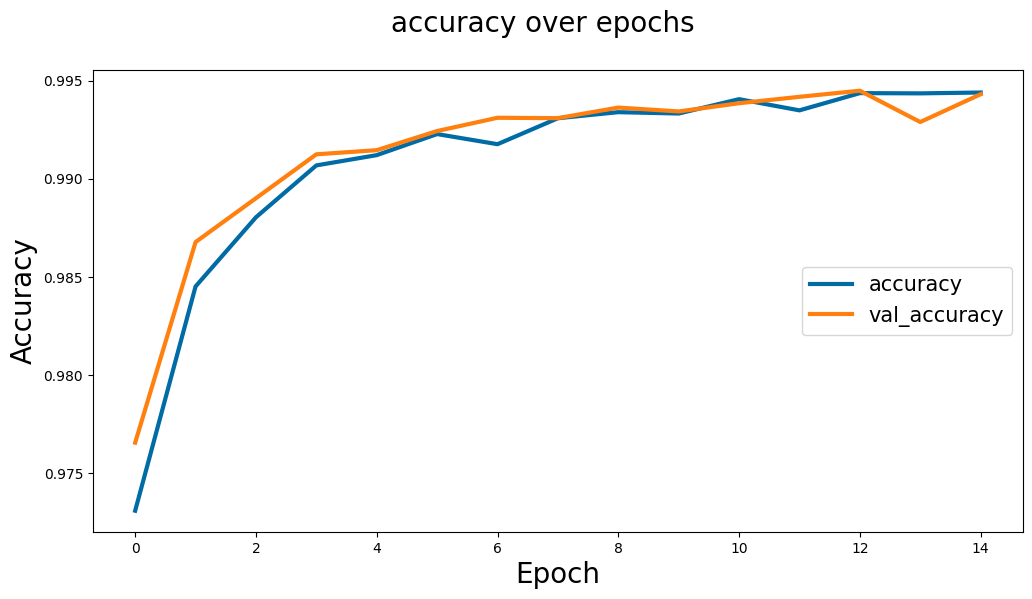

In [54]:
def plot_accuracy_history(history, metrics=["accuracy", "val_accuracy"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("accuracy over epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_accuracy_history(history)

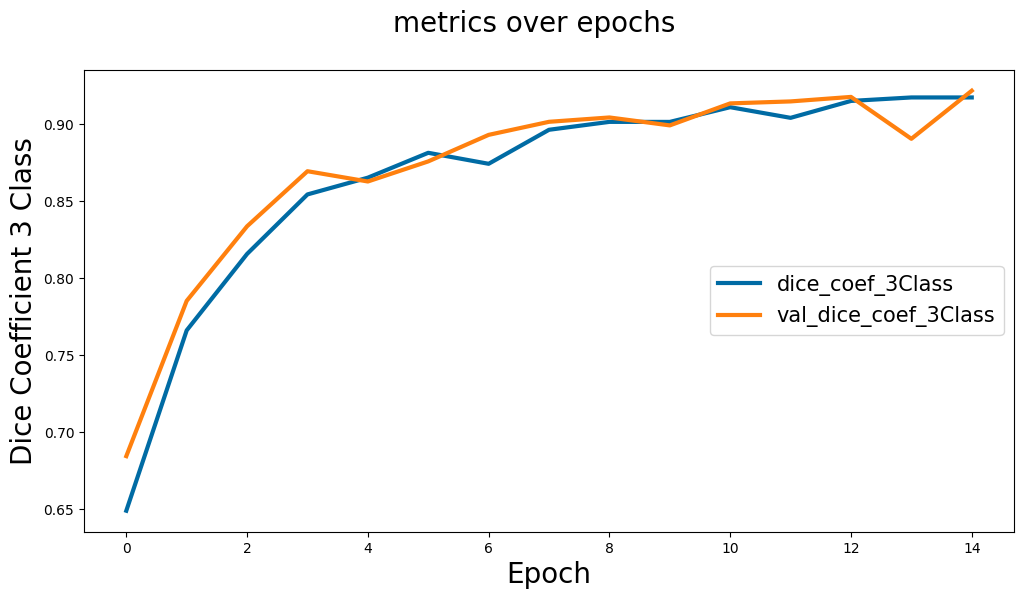

In [55]:
def plot_dice_history(history, metrics=["dice_coef_3Class","val_dice_coef_3Class"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_dice_history(history)

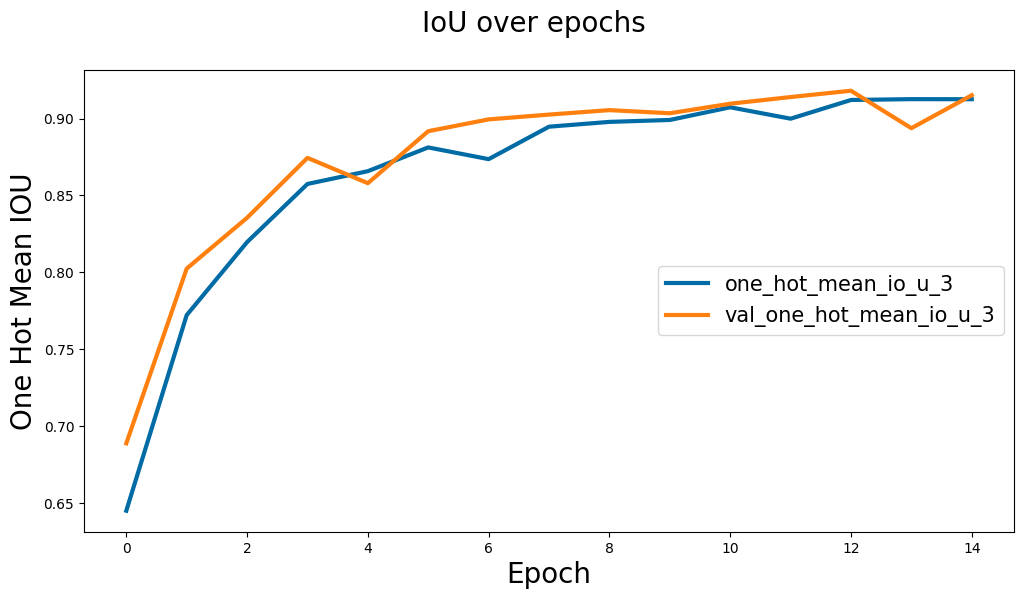

In [58]:
def plot_IoU_onehot_history(history, metrics=["one_hot_mean_io_u_3", "val_one_hot_mean_io_u_3"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("IoU over epochs", fontsize=20)
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_IoU_onehot_history(history)

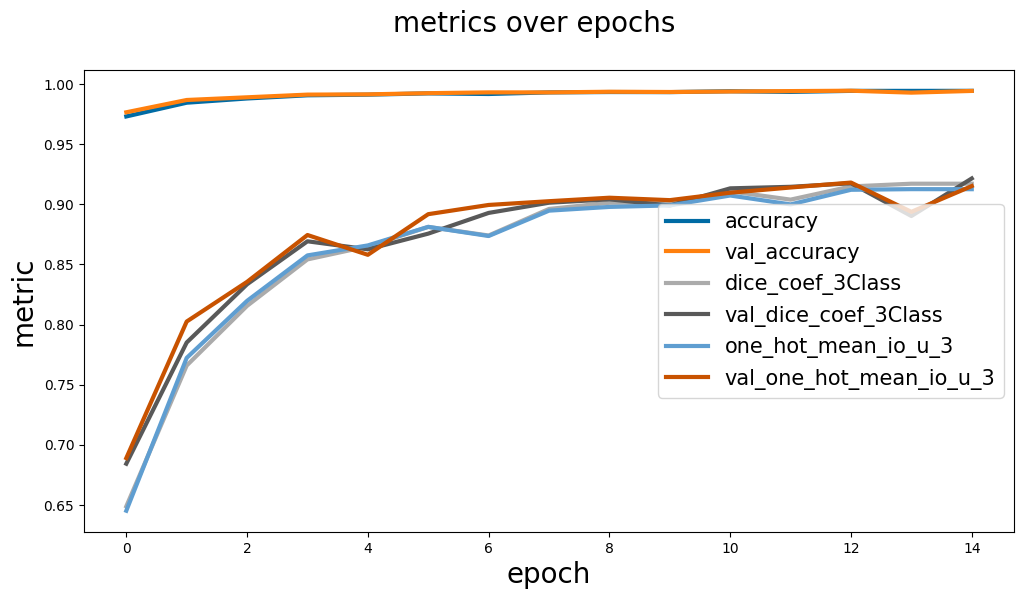

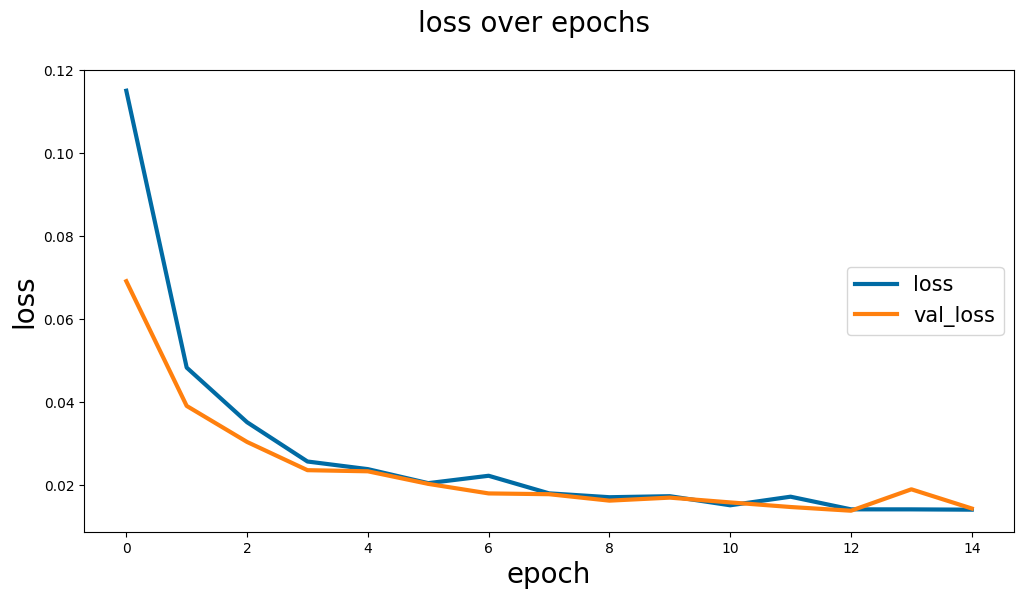

In [60]:
def plot_history(history, metrics=["accuracy", "val_accuracy","dice_coef_3Class","val_dice_coef_3Class", "one_hot_mean_io_u_3", "val_one_hot_mean_io_u_3"], losses=["loss", "val_loss"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

plot_history(history)

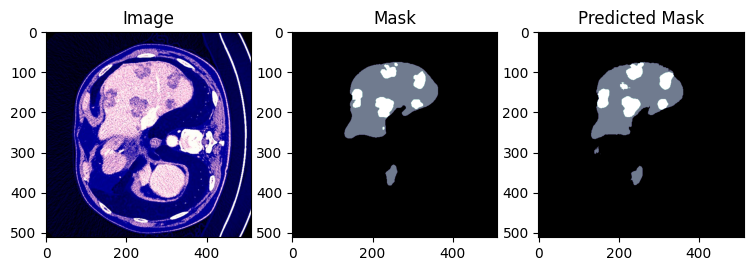

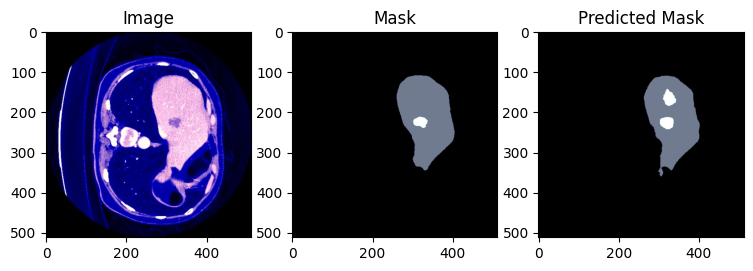

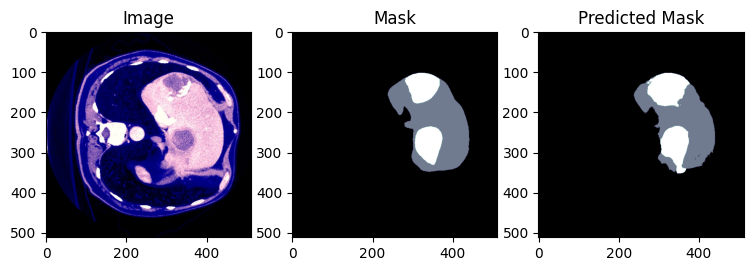

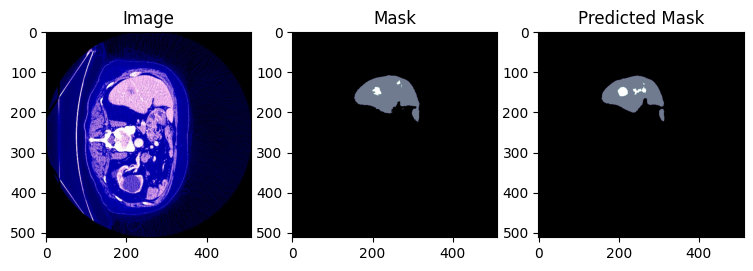

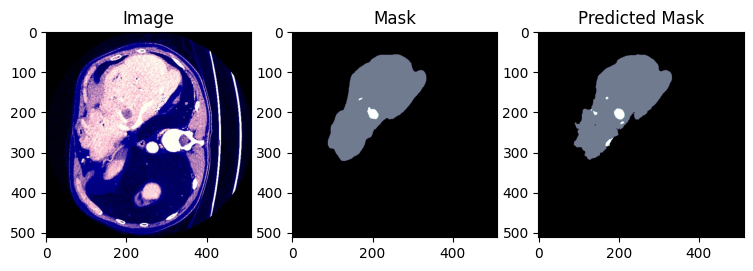

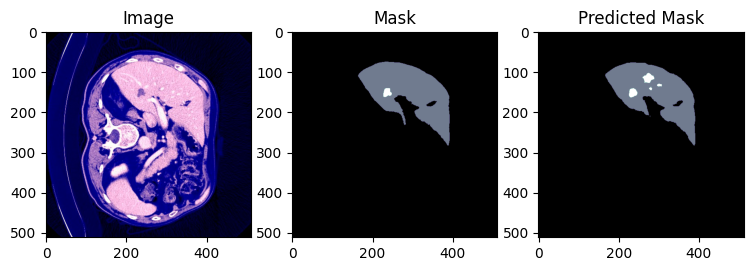

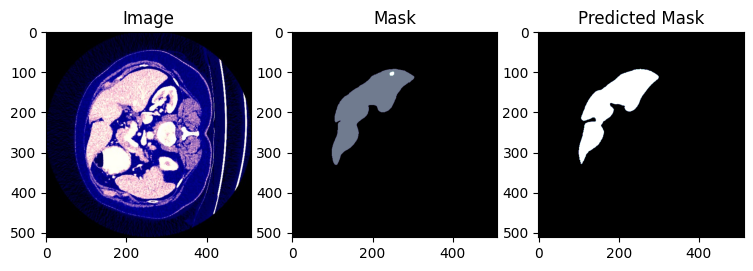

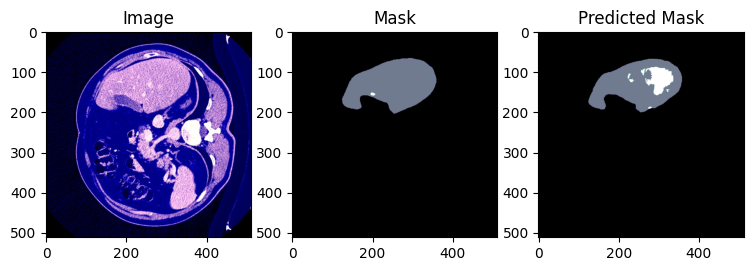

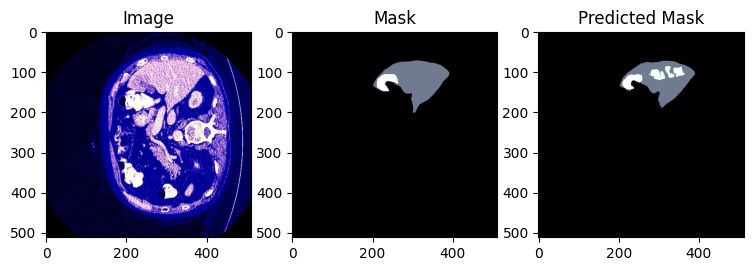

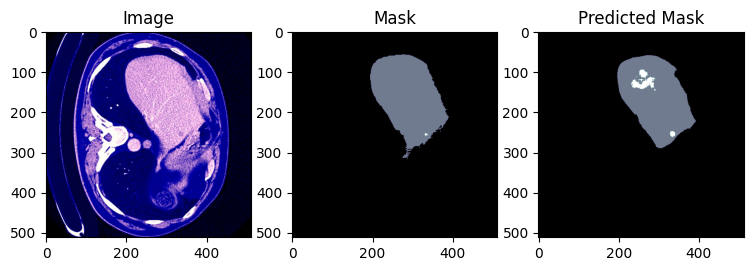

In [39]:
import random

l = random.sample(range(0,1078), 10)


for i in l:
    img = test_x[i]
    image = read_image(img)

    image = np.expand_dims(image,axis=0)
    # print(image.shape)
    prediction = model.predict(image).squeeze()
    prediction = np.argmax(prediction, axis=-1).astype(np.int32)
    
    
    # print(model.predict(image).squeeze().shape)

    visualize(image = read_image(test_x[i]), mask = read_mask(test_y[i]), predicted_mask = prediction)